In [ ]:
# in colab, please run:
!pip install transformers sentence-transformers datasets rouge_score nltk

     |████████████████████████████████| 3.3 MB 4.3 MB/s 
     |████████████████████████████████| 78 kB 6.7 MB/s 
     |████████████████████████████████| 298 kB 64.5 MB/s 
     |████████████████████████████████| 3.3 MB 22.3 MB/s 
     |████████████████████████████████| 596 kB 69.3 MB/s 
     |████████████████████████████████| 61 kB 375 kB/s 
     |████████████████████████████████| 895 kB 72.4 MB/s 
     |████████████████████████████████| 1.2 MB 56.2 MB/s 
     |████████████████████████████████| 1.1 MB 55.3 MB/s 
     |████████████████████████████████| 132 kB 57.5 MB/s 
     |████████████████████████████████| 243 kB 47.1 MB/s 
     |████████████████████████████████| 271 kB 58.6 MB/s 
     |████████████████████████████████| 192 kB 56.1 MB/s 
     |████████████████████████████████| 160 kB 54.7 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=67ac38f1873746bba57676a41a5cebbf601fa3a8384d0ee4246cef846d9a6214
  Stored in 

### [In-class version] Summarization

This notebook will guide you through the basics of test summarization within a nlp_cource seminar.

Later this day, the notebook will be replaced by a longer "homework" version.

In [ ]:
import nltk
import numpy as np
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import datasets
data = datasets.load_dataset("multi_news")
train_dataset, val_dataset = data['train'], data['validation']

SEMINAR_MODE = True

if SEMINAR_MODE:
    val_dataset = [val_dataset[i] for i in range(0, len(val_dataset), 5)]

Downloading:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/918 [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/257M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset multi_news downloaded and prepared to /root/.cache/huggingface/datasets/multi_news/default/1.0.0/2e145a8e21361ba4ee46fef70640ab946a3e8d425002f104d2cda99a9efca376. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
example = val_dataset[42]
sources = tuple(filter(len, map(str.strip, example['document'].split('|||||'))))

for i, source in enumerate(sources):
    print(f"SOURCE #{i}: {source}\n{'=' * 50}\n")
print("SUMMARY:\n", example['summary'])

SOURCE #0: (KUTV) A Vernal man has been charged with raping a 9-year-old girl while police say the girl's mother was getting high on meth. 
  
 Police identified the suspect as Larson James RonDeau, 36. 
  
 According to a probable cause statement, the mother and daughter were spending Easter weekend with a friend the mother met while in jail. The mother said there were also four adult men staying at the home. 
  
 Police said the mother and her friend agreed to get high on meth and went into the garage area, where they were for around 30 minutes. 
  
 When the mother returned, her daughter's dress was "pulled up past her waist" and she "appeared to be upset", according to the statement. The mother said she then called for a cab and returned with her daughter to their own apartment. 
  
 When questioned by her mother, police say the girl told her "four meneach raped her." The PC statement describes in greater detail the alleged attack. One man, according to police, threatened to kill t

In [ ]:
MAX_WORDS = 100

def summarize_baseline(doc: str, max_words=MAX_WORDS):
    sentences = nltk.sent_tokenize('\n'.join(doc.split('|||||')))
    summary = []
    num_words = 0
    
    for sent in sentences:
        sentence_length = len(nltk.word_tokenize(sent))
        if num_words + sentence_length > max_words:
            break
        num_words += sentence_length
        summary.append(sent)
    return ' '.join(summary)

In [ ]:
print(summarize_baseline(val_dataset[42]['document']))

(KUTV) A Vernal man has been charged with raping a 9-year-old girl while police say the girl's mother was getting high on meth. Police identified the suspect as Larson James RonDeau, 36. According to a probable cause statement, the mother and daughter were spending Easter weekend with a friend the mother met while in jail. The mother said there were also four adult men staying at the home.


### Okay, but is it any good?

In [ ]:
from rouge_score import rouge_scorer
from tqdm.auto import trange


scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
scores = scorer.score(target='The quick brown fox jumps over the lazy dog',
                      prediction='The quick brown dog jumps on the log.')
print(scores['rouge1'].fmeasure, scores['rougeL'].fmeasure)

0.7058823529411765 0.5882352941176471


In [ ]:
def compute_rouge_f1(dataset, predictions):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    r1 = []
    rL = []
    for doc, prediction in zip(dataset, predictions):
        scores = scorer.score(target=doc['summary'], prediction=prediction)
        r1.append(scores['rouge1'].fmeasure)
        rL.append(scores['rougeL'].fmeasure)
    return np.mean(r1), np.mean(rL)

In [ ]:
baseline_predictions = [summarize_baseline(row['document']) for row in val_dataset]
baseline_rouge1, baseline_rougeL = compute_rouge_f1(val_dataset, baseline_predictions)

print("Rouge-1:", baseline_rouge1)
print("Rouge-L:", baseline_rougeL)

if SEMINAR_MODE:
    assert abs(baseline_rouge1 - 0.26632) < 1e-4 and abs(baseline_rougeL - 0.14617) < 1e-4
    print("Well done!")

Rouge-1: 0.26632097864564386
Rouge-L: 0.14617077878973056
Well done!


### Neural extractive summarization

![](https://i.imgur.com/kkrzeq7.png)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase=True, max_features=50_000)
vectorizer.fit([item['document'] for item in train_dataset])
encode_func = lambda texts: vectorizer.transform(texts).toarray()

In [ ]:
doc = val_dataset[42]
documents = tuple(filter(len, map(str.strip, doc['document'].split('|||||'))))

sentences_by_doc = [nltk.sent_tokenize(doc) for doc in documents]
sentences = [sent for document in sentences_by_doc for sent in document]
sentence_lengths = np.array([len(nltk.word_tokenize(sent)) for sent in sentences])

sentence_embeddings = encode_func(sentences)
document_embeddings = encode_func(list(map('\n'.join, sentences_by_doc)))
print("Sentence embeddings shape:", sentence_embeddings.shape)
print("Document embedding shape:", document_embeddings.shape)

Sentence embeddings shape: (72, 50000)
Document embedding shape: (4, 50000)


In [ ]:
# Compute cosine similarities between each pair of sentences
from sklearn.metrics.pairwise import cosine_similarity

sentence_similarities = cosine_similarity(sentence_embeddings)

# ... and also between each sentence and each document
document_similarities = cosine_similarity(sentence_embeddings, document_embeddings)

assert sentence_similarities.shape == (len(sentences), len(sentences))
assert document_similarities.shape == (len(sentences), len(documents))

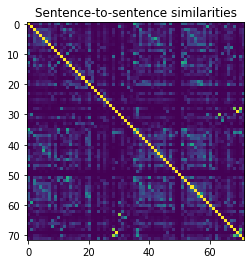

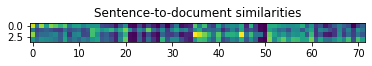

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.title("Sentence-to-sentence similarities")
plt.imshow(sentence_similarities)
plt.show()
plt.title("Sentence-to-document similarities")
plt.imshow(document_similarities.T)
plt.show()

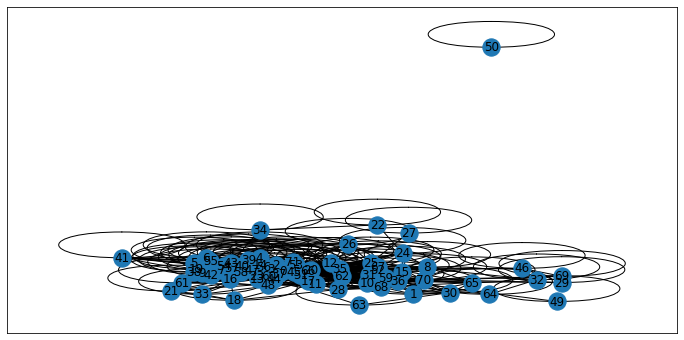

In [ ]:
import networkx

plt.figure(figsize=(12, 6))
networkx.draw_networkx(networkx.from_numpy_array(sentence_similarities > 0.1))

In [ ]:
def choose_summary_greedy(sentences, sentence_scores, sentence_similarities, sentence_lengths,
                          max_words=MAX_WORDS, sim_threshold=0.9):
    assert sentence_scores.shape == (len(sentences),)
    chosen_sentences = []
    max_similarities = np.zeros(len(sentences))
    num_words = 0

    for i in range(len(sentences)):
        mask = (sentence_lengths <= (max_words - num_words)) & (max_similarities < sim_threshold)
        if not np.any(mask):
            break

        best_sentence_index = np.argmax(sentence_scores * mask)

        chosen_sentences.append(sentences[best_sentence_index])


        max_similarities = np.maximum(max_similarities, sentence_similarities[best_sentence_index])
        num_words += sentence_lengths[best_sentence_index]
    
    return chosen_sentences

In [ ]:
sentence_scores = sentence_similarities.mean(axis=-1)

summary_sentences = choose_summary_greedy(
    sentences, sentence_scores, sentence_similarities, sentence_lengths,
    max_words=MAX_WORDS, sim_threshold=0.7)
print(summary_sentences)

['One of the men allegedly told the girl he would kill her if she ever reported the incident, and the threat was made during the alleged rape.', "Related story: Grandmother of 9-year-old Utah girl allegedly raped by four men: ‘I want justice’ \n  \n RonDeau told police that the other three men had traveled to Montana for personal business along with the woman who the girl's mother had been there to visit, Glynda RonDeau.", 'When questioned by her mother, police say the girl told her "four meneach raped her."']


### Putting it all together

In [ ]:
def summarize_one(document, max_words=MAX_WORDS, sim_threshold=0.7):
    documents = tuple(filter(len, map(str.strip, document.split('|||||'))))

    sentences_by_doc = [nltk.sent_tokenize(doc) for doc in documents]
    sentences = [sent for document in sentences_by_doc for sent in document]
    sentence_lengths = np.array([len(nltk.word_tokenize(sent)) for sent in sentences])
    
    # use encode_func to compute embedding matrices
    sentence_embeddings = encode_func(sentences)
    document_embeddings = encode_func(list(map('\n'.join, sentences_by_doc)))

    # compute pairwise similarities between sentences and sentence-document pairs
    sentence_similarities = cosine_similarity(sentence_embeddings)
    document_similarities = cosine_similarity(sentence_embeddings, document_embeddings)
    
    
    # Compute the scores s.t. higher score corresponds to better sentences.
    # There are many ways to devise such a function, try them for yourself and see which works best.
    # Here's a few inspirations:
    # - mean similarity to 3 nearest sentences [please start with this one]
    # - page-rank scores that use similarity matrix as connectivity matrix
    # - distance to the nearest cluster in embedding space using k-means clustering

    k = min(4, sentence_embeddings.shape[0] - 1) # k=4 (not 3) because the nearest sentense is the sentense itself
    sentence_scores = np.mean(np.partition(sentence_similarities, k, axis=1)[:,k:], axis=1)
    
    summary_sentences = choose_summary_greedy(
        sentences, sentence_scores, sentence_similarities, sentence_lengths,
        max_words=max_words, sim_threshold=sim_threshold)
    
    return '\n'.join(summary_sentences)

In [ ]:
print(summarize_one(val_dataset[2]['document']))

According to the NCC, its member producers and processors account for about 95 percent of the chicken produced in the U.S. 
  
 "This study evaluates only two chicken nugget samples out of the billions of chicken nuggets that are made every year," Peterson said.
DeShazo and Bigler's conclusion: "Chicken nuggets are mostly fat, and their name is a misnomer."
"Chicken nuggets tend to have an elevated fat content because they are breaded and fried.
The nuggets came from two national fast food chains in Jackson.


In [ ]:
our_summaries = []
for i in trange(len(val_dataset)):
    our_summaries.append(summarize_one(val_dataset[i]['document']))

  0%|          | 0/1125 [00:00<?, ?it/s]

In [ ]:
our_rouge1, our_rougel = compute_rouge_f1(val_dataset, our_summaries)

print("Rouge-1:", our_rouge1)
print("Rouge-L:", our_rougel)

Rouge-1: 0.31641945102092733
Rouge-L: 0.16472024986858746


### Can we do better than TF-IDF?

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/LaBSE').train(False)

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/804 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/461 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

In [ ]:
emb1, emb2, emb3, emb4 = model.encode(
    ['Hello, world!', 'Greeting, universe!', 'Hello, John!', "A cat sat on the mat."]
)

In [ ]:
print("Sim(hello world, hello john) =", emb1 @ emb3)
print("Sim(hello world, greetings universe) =", emb1 @ emb2)
print("Sim(hello world, a cat sat on the mat)=", emb1 @ emb4)

Sim(hello world, hello john) = 0.72537374
Sim(hello world, greetings universe) = 0.7909731
Sim(hello world, a cat sat on the mat)= 0.16162992


In [ ]:
encode_func = model.encode

Sentence embeddings shape: (32, 768)
Document embedding shape: (2, 768)


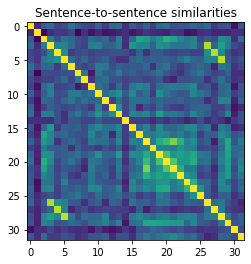

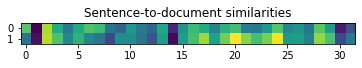

In [ ]:
doc = val_dataset[50]
documents = tuple(filter(len, map(str.strip, doc['document'].split('|||||'))))

sentences_by_doc = [nltk.sent_tokenize(doc) for doc in documents]
sentences = [sent for document in sentences_by_doc for sent in document]
sentence_lengths = np.array([len(nltk.word_tokenize(sent)) for sent in sentences])

sentence_embeddings = encode_func(sentences)
document_embeddings = encode_func(list(map('\n'.join, sentences_by_doc)))
print("Sentence embeddings shape:", sentence_embeddings.shape)
print("Document embedding shape:", document_embeddings.shape)

sentence_similarities = sentence_embeddings @ sentence_embeddings.T
document_similarities = sentence_embeddings @ document_embeddings.T

plt.title("Sentence-to-sentence similarities")
plt.imshow(sentence_similarities)
plt.show()
plt.title("Sentence-to-document similarities")
plt.imshow(document_similarities.T)
plt.show()


In [ ]:
our_summaries = []
for i in trange(len(val_dataset)):
    our_summaries.append(summarize_one(val_dataset[i]['document']))

  0%|          | 0/1125 [00:00<?, ?it/s]

In [ ]:
our_rouge1, our_rougel = compute_rouge_f1(val_dataset, our_summaries)

print("Rouge-1:", our_rouge1)
print("Rouge-L:", our_rougel)

Rouge-1: 0.3064068452381045
Rouge-L: 0.16078173167044066
Rouge-1: 0.3064068452381045
Rouge-L: 0.16078173167044066


### Call the cavalry!

[Pegasus](https://arxiv.org/abs/1912.08777) is an *abstractive* summarization model based on a large pre-trained transformer. Before doing any summarizaton, the model is pre-trained on a combination of MLM and a specialized objective called Gap Sentence Generation: predicting an entire sentence omitted from the middle of the text.

In [ ]:
import transformers
pegasus = transformers.pipeline("summarization", "google/pegasus-multi_news")

In [ ]:
print(example['document'])

In [ ]:
document = example['document'].split('|||||')[0]
print("SUMMARY:", pegasus([document], min_length=5, max_length=100)[0]['summary_text'])